# Homework 3

We first import the needed libraries and set the elements we need for the rest of the Homework.

In [1]:
# Used to look for the saved data sheets
IMAGE_FOLDER = 'Data/Images/'
DATA_EUROPE = 'Data/une_rt_a.xls'
DATA_SWITZERLAND_BY_AGE = 'Data/chomage_age.xlsx'
DATA_SWITZERLAND_BY_NATIONALITY = 'Data/2_1 Taux de chômage.xlsx'

In [2]:
swiss_geo_path = r'ch-cantons.topojson.json'
europe_geo_path = r'europe.topojson.json'

In [3]:
# Importing libraries
import os
import json
import pandas as pd
import seaborn as sns #might not be useful
import folium
from IPython.display import Image #permits to show images

In [4]:
#Verifying we have the right version
folium.__version__ == '0.5.0'

True

## Unemployment in Europe

The very first thing we have to think about is what data we want to use. Eurostat has a lot of types of information, even more so, has information per country, but also per province/state of some countries (known as NUTS 2 regions). Thus, we have to determine what kind of information - and how much - we want to show.

Thus, we decide to take the **yearly** average for the unemployment rates and not the monthly ones, thus getting data from 2016 and not from 2017. For the monthly rates, we could have information for the beginning of this year, but we choose against it. This also permits to not have any fluctuation due to seasonal workers that would not be seen as unemployed for a time.

Secondly, seeing as the idea is to compare the unemployment rate of Europe to that of Switzerland, it would be more appropriate to take the data by country rather than that per NUTS 2 region, even more so seeing as Switzerland is cut in several in that dataset. So, to be able to compare it to Switzerland as a whole, we should have Switzerland as only one entity.

Therefore, we also need data that includes Switzerland, as it is not always the case for all files about unemployment in Europe. Thus, we had to dig a bit deeper and find data on unemployment according to age, sex and nationality (which contains rates for Switzerland, compared to data in the main indicators), which restricts it to people of age 15 to 74. This is actually what we want as those are the "adults" that could be potentially working already, and people that are younger or older should not count in our rates, as they aren't aprt of the working force.

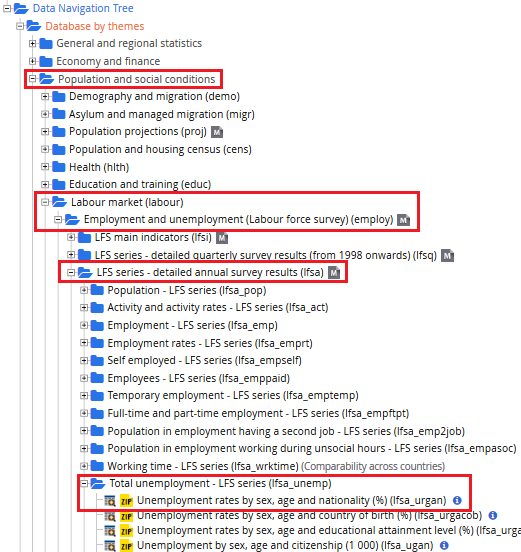

In [5]:
Image(IMAGE_FOLDER + 'euro01.png')

We also had the option to download the data in several different types of files, like HTML, CSV, TSV or XLS. We choose to download the data in a XLS format.

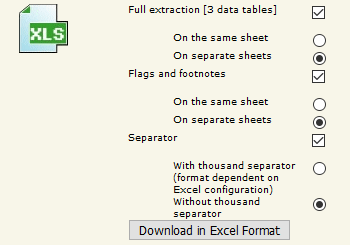

In [6]:
Image(IMAGE_FOLDER + 'euro02.png')

In [7]:
europe_unemployed = pd.read_excel(DATA_EUROPE, header=10)

In [8]:
europe_unemployed.head()

,GEO/TIME,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,European Union (28 countries),7.1,7.0,8.9,9.5,9.6,10.4,10.8,10.2,9.4,8.6
1,European Union (27 countries),7.1,7.0,8.9,9.5,9.6,10.4,10.8,10.2,9.4,8.5
2,European Union (15 countries),7.0,7.1,9.0,9.5,9.6,10.6,11.0,10.5,9.8,9.1
3,Euro area (19 countries),7.4,7.5,9.5,10.1,10.1,11.3,12.0,11.6,10.9,10.0
4,Euro area (18 countries),7.4,7.5,9.5,10.0,10.1,11.3,12.0,11.6,10.9,10.1


## Unemployment in Switzerland

Here, we need several things to be contained in our data, as this is a question that contains several points. First, we need to see each canton individually, but also have some statistics of people who alreay have a job but search for another one. 

First, on amstat, we go to the category "Chômeurs" and then look at the details.

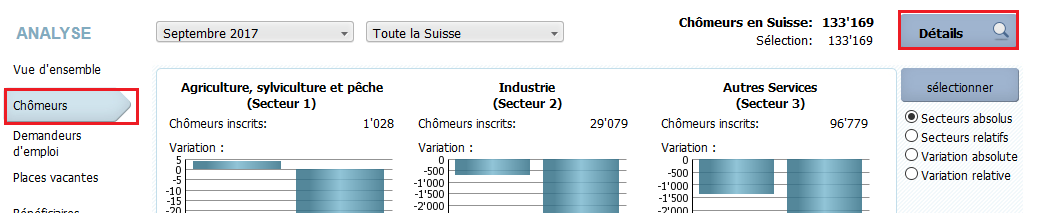

In [9]:
Image(IMAGE_FOLDER + 'amstat01.png')

Then, we choose "Taux de chômage".

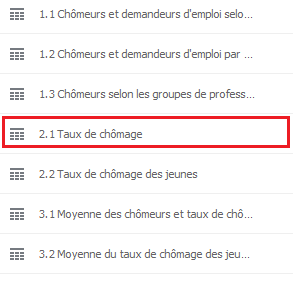

In [10]:
Image(IMAGE_FOLDER + 'amstat02.png')

 We also choose to look at the whole year in review, which means all of 2017, so that we can maybe do a few comparaisons. Thus we choose "À partir du janvier de l'année sous revue". 

We also select three indicators: "Chômeurs inscrits", "Chômeurs jeunes" and "Chômeurs de longue durée" to see all the types of unemployed people.

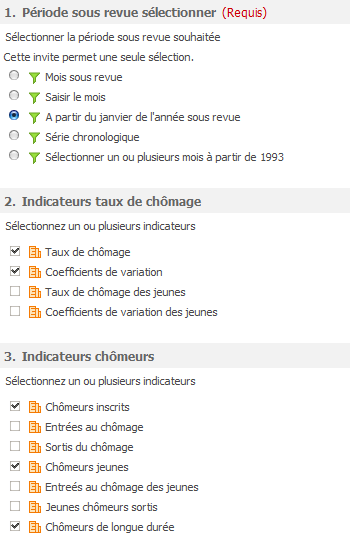

In [11]:
Image(IMAGE_FOLDER + 'amstat03.png')

We take both "Demandeur d'emploi" and "Demandeur d'emploi non chômeur" as to know who is or isn't really unemployed.

Next, for the geography part, we select all three (Language, region and canton), mainly so that we can maybe use this dataset later for the Röstigraben question.

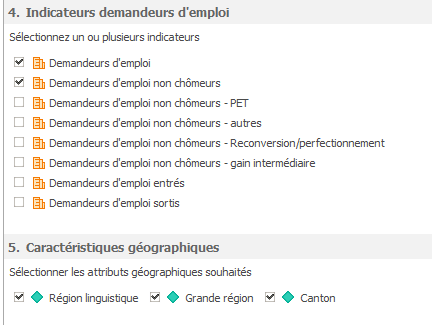

In [12]:
Image(IMAGE_FOLDER + 'amstat04.png')

Lastly, we also select the option "Classes d'âge 15-24, 25-49, 50 ans et plus" as we will be able to use it to see the different categories of unemplyed people and use it in the last part of the question.

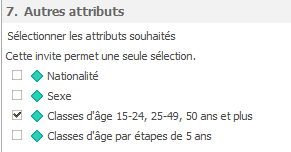

In [13]:
Image(IMAGE_FOLDER + 'amstat05.png')

Now we can select what type of file we want the file in. We chose the XLS file as "Excel avec texte clair" as the other XLS files didn't seem appropriate to us, because of a few problems with the colapsing of rows (for the regions).

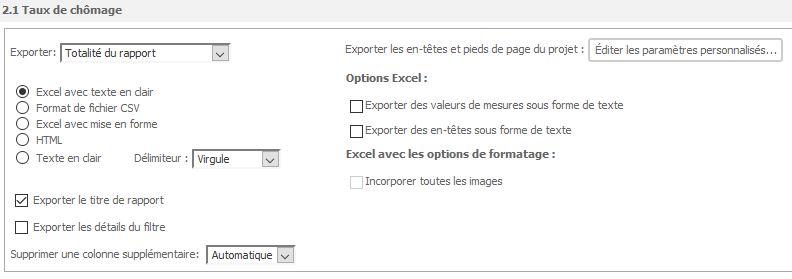

In [14]:
Image(IMAGE_FOLDER + 'amstat07.png')

In [15]:
swiss_unemployed = pd.read_excel(DATA_SWITZERLAND_BY_AGE, header=[2,3])

In [16]:
swiss_unemployed.head()

Région linguistique      Grande région                                Canton  \
                    Unnamed: 0_level_1 Unnamed: 1_level_1 Unnamed: 2_level_1   
Suisse alémanique                  2.0  Espace Mittelland              Berne   
Suisse alémanique                  2.0  Espace Mittelland              Berne   
Suisse alémanique                  2.0  Espace Mittelland              Berne   
Suisse alémanique                  2.0  Espace Mittelland            Soleure   
Suisse alémanique                  2.0  Espace Mittelland            Soleure   

Région linguistique Classes d'âge 15-24, 25-49, 50 ans et plus  \
                                            Unnamed: 3_level_1   
Suisse alémanique                                          1.0   
Suisse alémanique                                          2.0   
Suisse alémanique                                          3.0   
Suisse alémanique                                          1.0   
Suisse alémanique                                          2.0   

Région linguistique                       Mois    Janvier 2017  \
                    Unnamed: 4_level_1 Mesures Taux de chômage   
Suisse alémanique            15-24 ans     NaN             3.2   
Suisse alémanique            25-49 ans     NaN             3.2   
Suisse alémanique       50 ans et plus     NaN             2.6   
Suisse alémanique            15-24 ans     NaN             3.4   
Suisse alémanique            25-49 ans     NaN             3.4   

Région linguistique                                              \
                    Coefficients de variation Chômeurs inscrits   
Suisse alémanique                           B              2324   
Suisse alémanique                           A             10054   
Suisse alémanique                           A              4576   
Suisse alémanique                           B               676   
Suisse alémanique                           A              2733   

Région linguistique                               ...                 \
                    Chômeurs jeunes               ...                  
Suisse alémanique              2324               ...                  
Suisse alémanique                 0               ...                  
Suisse alémanique                 0               ...                  
Suisse alémanique               676               ...                  
Suisse alémanique                 0               ...                  

Région linguistique             Octobre 2017                      \
                    Chômeurs de longue durée Demandeurs d'emploi   
Suisse alémanique                          0                   0   
Suisse alémanique                          0                   0   
Suisse alémanique                          0                   0   
Suisse alémanique                          0                   0   
Suisse alémanique                          0                   0   

Région linguistique                                            Total  \
                    Demandeurs d'emploi non chômeurs Taux de chômage   
Suisse alémanique                                  0             2.5   
Suisse alémanique                                  0             2.5   
Suisse alémanique                                  0             2.1   
Suisse alémanique                                  0             2.6   
Suisse alémanique                                  0             2.7   

Région linguistique                                              \
                    Coefficients de variation Chômeurs inscrits   
Suisse alémanique                           B             17841   
Suisse alémanique                           A             78842   
Suisse alémanique                           A             37473   
Suisse alémanique                           B              5232   
Suisse alémanique                           A             21059   

Région linguistique                                           \
                    Ch

### Differences in unemployment between foreigners and natives

Here we have two different questions again: one about the difference in employment regarding nationality, and the second regarding age. Seeing as we already have the information regarding age in the first dataset, we do not need to find another one. Regarding nationality, we proceed similarly as above.

Thus, we choose exactly the same information as before but at the last option, we select "Nationalité" instead of the age classes.

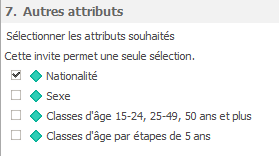

In [17]:
Image(IMAGE_FOLDER + 'amstat06.png')

In [18]:
swiss_foreign_unemployed = pd.read_excel(DATA_SWITZERLAND_BY_NATIONALITY, header=[0,1], index_col=None) 

FileNotFoundError: [Errno 2] No such file or directory: 'Data/2_1 Taux de chômage.xlsx'

In [ ]:
del swiss_foreign_unemployed['Mois'] #remove empty line
del swiss_foreign_unemployed['Total'] #only interessted in september

In [ ]:
 swiss_foreign_unemployed.dropna(inplace=True) #final 'total' column is NA

In [ ]:
swiss_foreign_unemployed.head()

In [ ]:
swiss_map_data_2 = swiss_foreign_unemployed[['Canton', 'Nationalité', 'Septembre 2017']]

In [ ]:
swiss_map_data_2

### The Röstigraben